In [ ]:
!pip install mediapipe

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 34.5/34.5 MB 25.4 MB/s eta 0:00:00


In [ ]:
import math
import cv2
import numpy as np
from time import time
import mediapipe as mp
import matplotlib.pyplot as plt


In [ ]:
# Initializing mediapipe pose class.
mp_pose = mp.solutions.pose

# Setting up the Pose function.
pose = mp_pose.Pose(static_image_mode=True, min_detection_confidence=0.3, model_complexity=2)

# Initializing mediapipe drawing class, useful for annotation.
mp_drawing = mp.solutions.drawing_utils

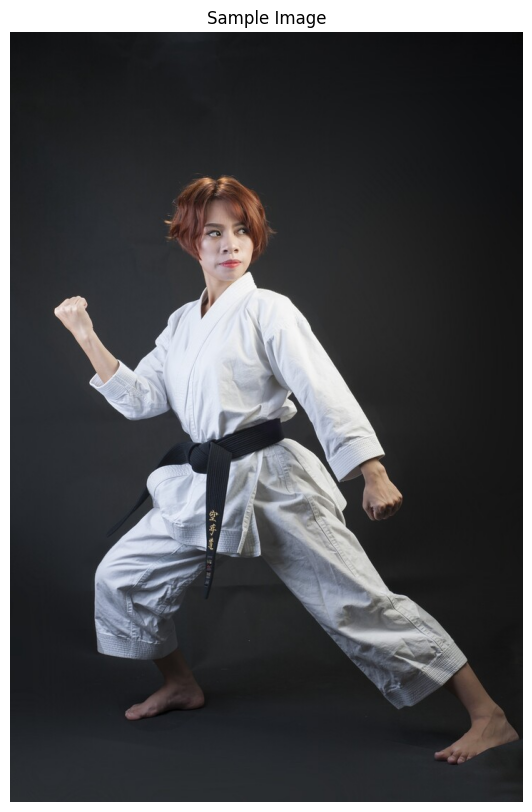

In [ ]:
sample_img = cv2.imread('/content/drive/MyDrive/sample.jpg')

# Specify a size of the figure.
plt.figure(figsize = [10, 10])

# Display the sample image, also convert BGR to RGB for display.
plt.title("Sample Image");plt.axis('off');plt.imshow(sample_img[:,:,::-1]);plt.show()

In [ ]:
# Perform pose detection after converting the image into RGB format.
results = pose.process(cv2.cvtColor(sample_img, cv2.COLOR_BGR2RGB))

# Check if any landmarks are found.
if results.pose_landmarks:

    # Iterate two times as we only want to display first two landmarks.
    for i in range(2):

        # Display the found normalized landmarks.
        print(f'{mp_pose.PoseLandmark(i).name}:\n{results.pose_landmarks.landmark[mp_pose.PoseLandmark(i).value]}')


NOSE:
x: 0.42638200521469116
y: 0.2825169861316681
z: -0.5677525997161865
visibility: 1.0

LEFT_EYE_INNER:
x: 0.4352526068687439
y: 0.26287171244621277
z: -0.5314675569534302
visibility: 0.9999998807907104



In [ ]:
# Retrieve the height and width of the sample image.
image_height, image_width, _ = sample_img.shape

# Check if any landmarks are found.
if results.pose_landmarks:

    # Iterate two times as we only want to display first two landmark.
    for i in range(2):

        # Display the found landmarks after converting them into their original scale.
        print(f'{mp_pose.PoseLandmark(i).name}:')
        print(f'x: {results.pose_landmarks.landmark[mp_pose.PoseLandmark(i).value].x * image_width}')
        print(f'y: {results.pose_landmarks.landmark[mp_pose.PoseLandmark(i).value].y * image_height}')
        print(f'z: {results.pose_landmarks.landmark[mp_pose.PoseLandmark(i).value].z * image_width}')
        print(f'visibility: {results.pose_landmarks.landmark[mp_pose.PoseLandmark(i).value].visibility}\n')


NOSE:
x: 306.56866174936295
y: 305.11834502220154
z: -408.2141191959381
visibility: 1.0

LEFT_EYE_INNER:
x: 312.94662433862686
y: 283.9014494419098
z: -382.1251734495163
visibility: 0.9999998807907104



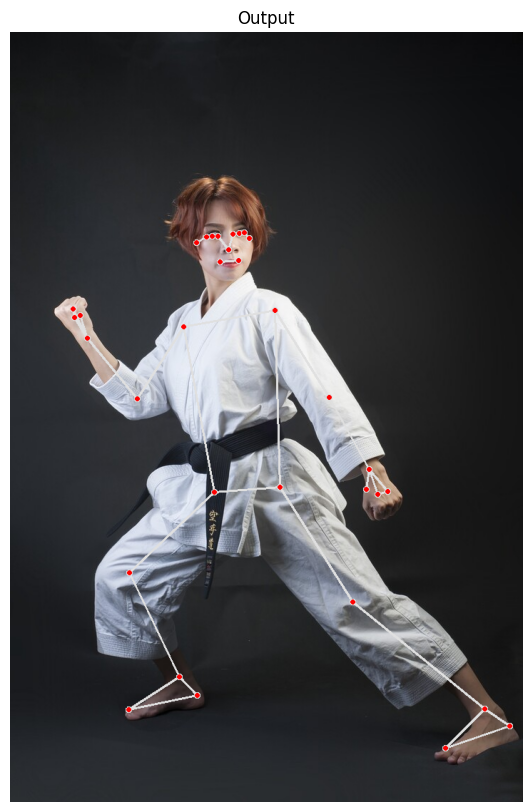

In [ ]:
# Create a copy of the sample image to draw landmarks on.
img_copy = sample_img.copy()

# Check if any landmarks are found.
if results.pose_landmarks:

    # Draw Pose landmarks on the sample image.
    mp_drawing.draw_landmarks(image=img_copy, landmark_list=results.pose_landmarks, connections=mp_pose.POSE_CONNECTIONS)

    # Specify a size of the figure.
    fig = plt.figure(figsize = [10, 10])

    # Display the output image with the landmarks drawn, also convert BGR to RGB for display.
    plt.title("Output");plt.axis('off');plt.imshow(img_copy[:,:,::-1]);plt.show()

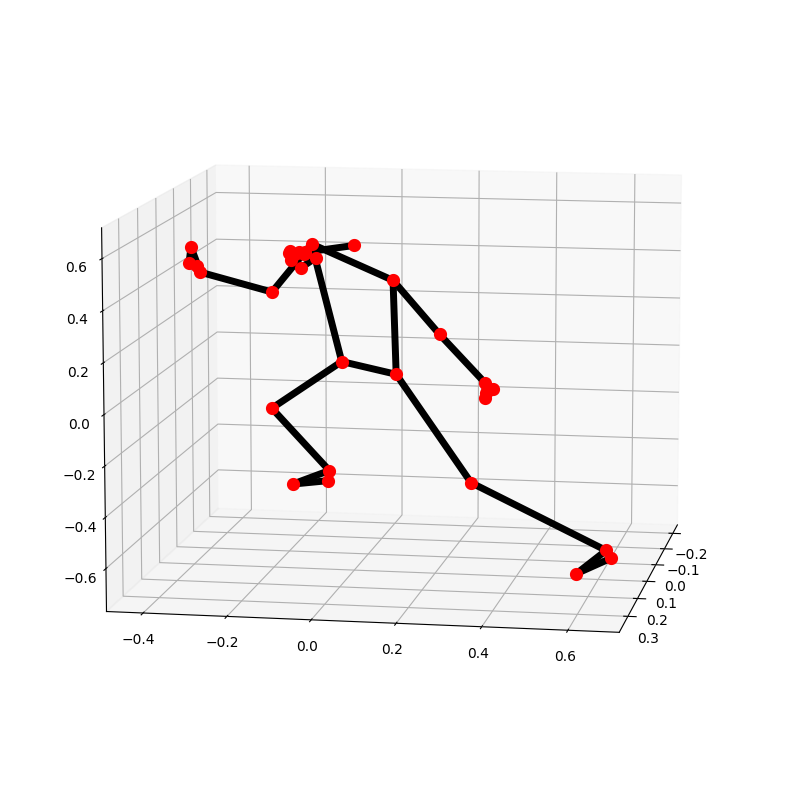

In [ ]:
# Plot Pose landmarks in 3D.
mp_drawing.plot_landmarks(results.pose_world_landmarks, mp_pose.POSE_CONNECTIONS)


In [ ]:
def detectPose(image, pose, display=True):

    # Create a copy of the input image.
    output_image = image.copy()

    # Convert the image from BGR into RGB format.
    imageRGB = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    # Perform the Pose Detection.
    results = pose.process(imageRGB)

    # Retrieve the height and width of the input image.
    height, width, _ = image.shape

    # Initialize a list to store the detected landmarks.
    landmarks = []

    # Check if any landmarks are detected.
    if results.pose_landmarks:

        # Draw Pose landmarks on the output image.
        mp_drawing.draw_landmarks(image=output_image, landmark_list=results.pose_landmarks,
                                  connections=mp_pose.POSE_CONNECTIONS)

        # Iterate over the detected landmarks.
        for landmark in results.pose_landmarks.landmark:

            # Append the landmark into the list.
            landmarks.append((int(landmark.x * width), int(landmark.y * height),
                                  (landmark.z * width)))

    # Check if the original input image and the resultant image are specified to be displayed.
    if display:

        # Display the original input image and the resultant image.
        plt.figure(figsize=[22,22])
        plt.subplot(121);plt.imshow(image[:,:,::-1]);plt.title("Original Image");plt.axis('off');
        plt.subplot(122);plt.imshow(output_image[:,:,::-1]);plt.title("Output Image");plt.axis('off');

        # Also Plot the Pose landmarks in 3D.
        mp_drawing.plot_landmarks(results.pose_world_landmarks, mp_pose.POSE_CONNECTIONS)

    # Otherwise
    else:

        # Return the output image and the found landmarks.
        return output_image, landmarks

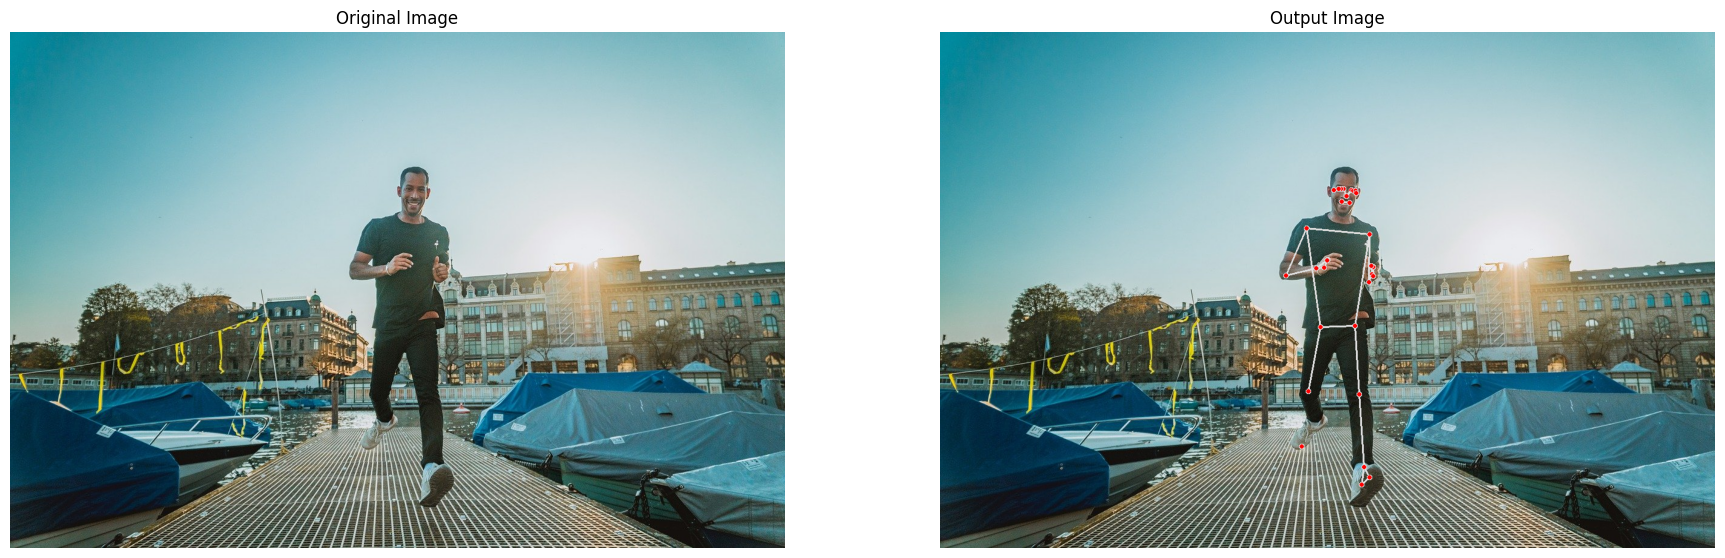

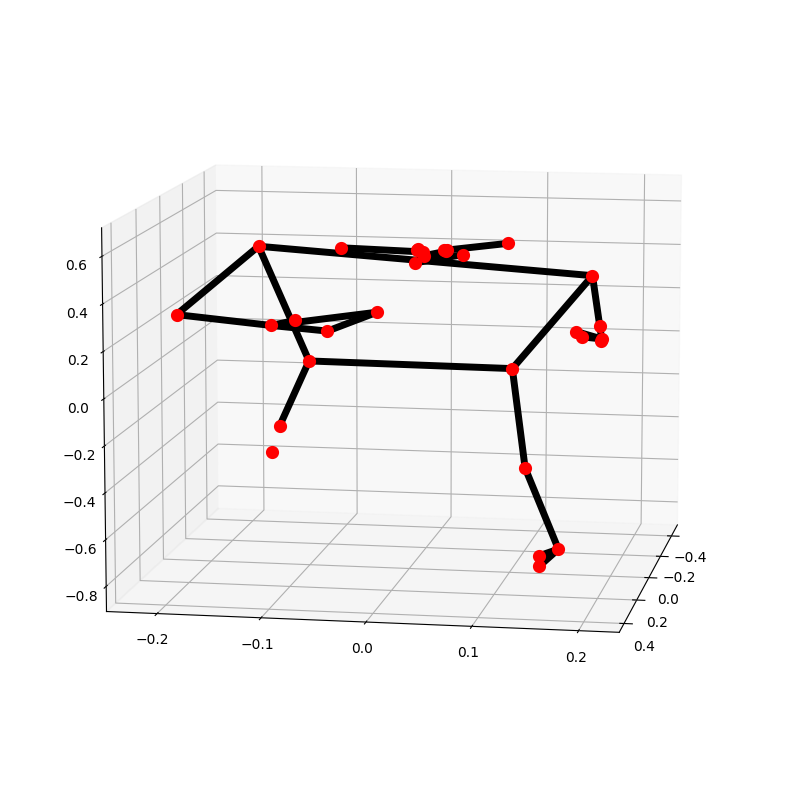

In [ ]:
# Read another sample image and perform pose detection on it.
image = cv2.imread('/content/drive/MyDrive/sample1.jpg')
detectPose(image, pose, display=True)

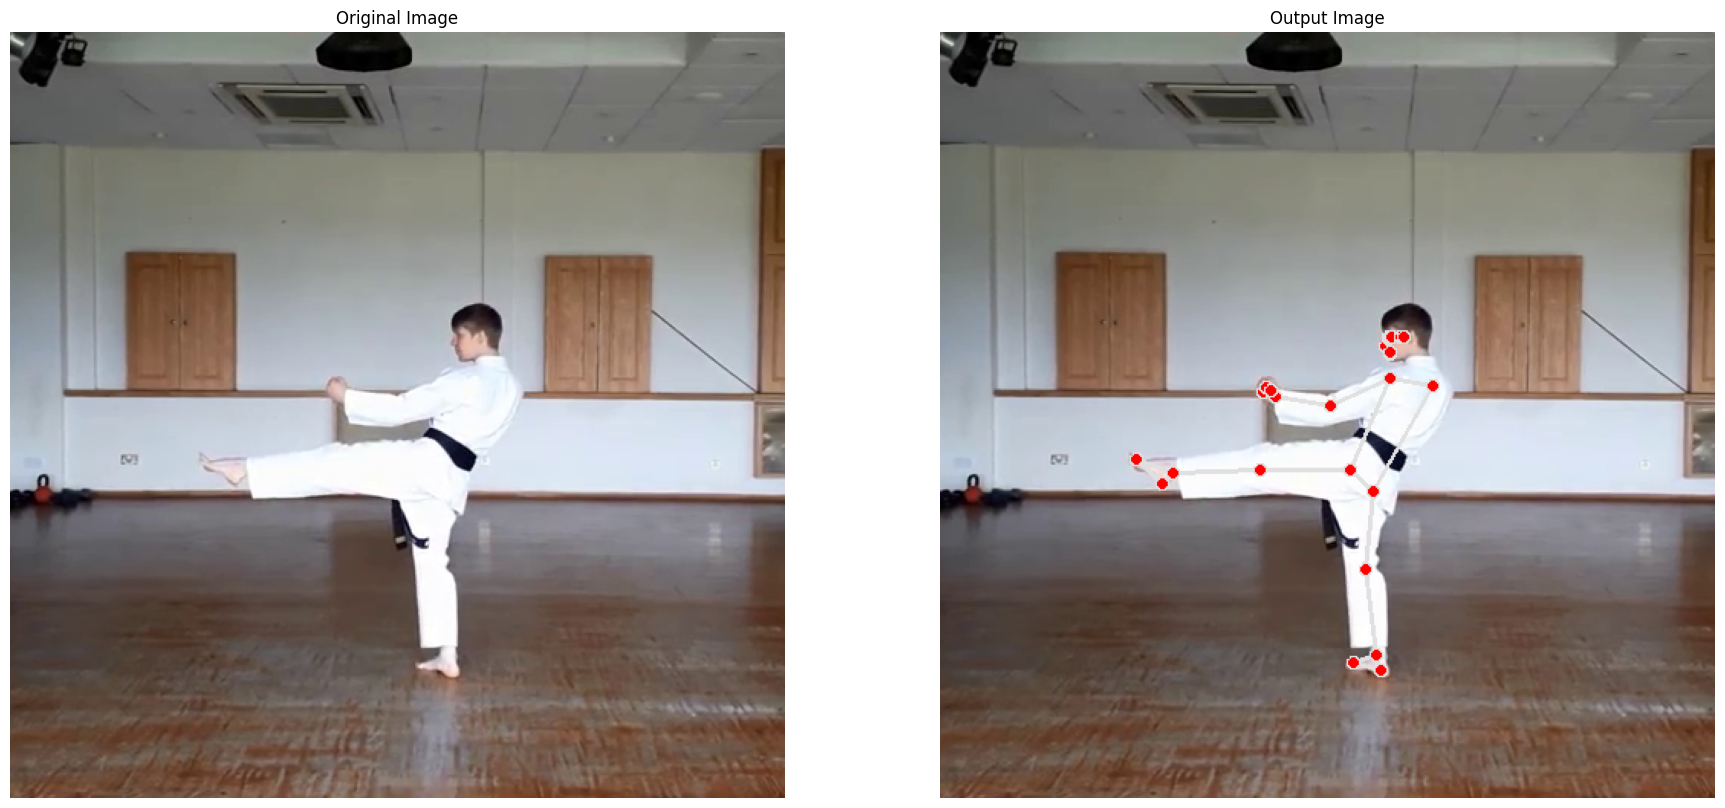

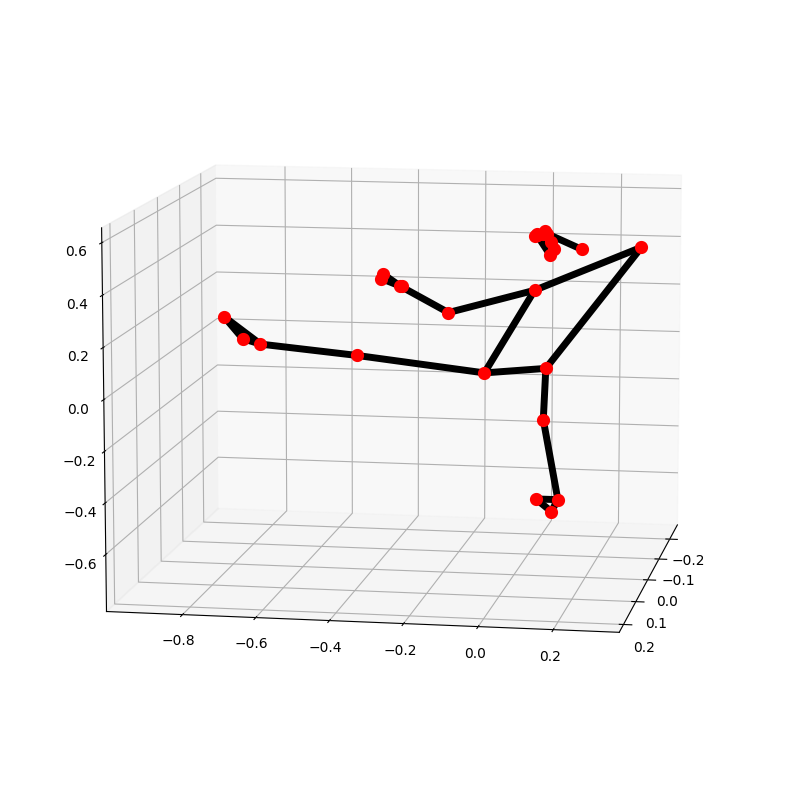

In [ ]:
image = cv2.imread('/content/drive/MyDrive/MoveMatch-main/reference_images/ref_2.png')
detectPose(image, pose, display=True)

In [ ]:
def calculateAngle(landmark1, landmark2, landmark3):


    # Get the required landmarks coordinates.
    x1, y1, _ = landmark1
    x2, y2, _ = landmark2
    x3, y3, _ = landmark3

    # Calculate the angle between the three points
    angle = math.degrees(math.atan2(y3 - y2, x3 - x2) - math.atan2(y1 - y2, x1 - x2))

    # Check if the angle is less than zero.
    if angle < 0:

        # Add 360 to the found angle.
        angle += 360

    # Return the calculated angle.
    return angle

In [ ]:
angle = calculateAngle((558, 326, 0), (642, 333, 0), (718, 321, 0))

# Display the calculated angle.
print(f'The calculated angle is {angle}')

The calculated angle is 166.26373169437744


In [ ]:
def classifyPose(landmarks, output_image, display=False):
    '''
    This function classifies yoga poses depending upon the angles of various body joints.
    Args:
        landmarks: A list of detected landmarks of the person whose pose needs to be classified.
        output_image: A image of the person with the detected pose landmarks drawn.
        display: A boolean value that is if set to true the function displays the resultant image with the pose label
        written on it and returns nothing.
    Returns:
        output_image: The image with the detected pose landmarks drawn and pose label written.
        label: The classified pose label of the person in the output_image.

    '''

    # Initialize the label of the pose. It is not known at this stage.
    label = 'Unknown Pose'

    # Specify the color (Red) with which the label will be written on the image.
    color = (0, 0, 255)

    # Calculate the required angles.
    #----------------------------------------------------------------------------------------------------------------

    # Get the angle between the left shoulder, elbow and wrist points.
    left_elbow_angle = calculateAngle(landmarks[mp_pose.PoseLandmark.LEFT_SHOULDER.value],
                                      landmarks[mp_pose.PoseLandmark.LEFT_ELBOW.value],
                                      landmarks[mp_pose.PoseLandmark.LEFT_WRIST.value])

    # Get the angle between the right shoulder, elbow and wrist points.
    right_elbow_angle = calculateAngle(landmarks[mp_pose.PoseLandmark.RIGHT_SHOULDER.value],
                                       landmarks[mp_pose.PoseLandmark.RIGHT_ELBOW.value],
                                       landmarks[mp_pose.PoseLandmark.RIGHT_WRIST.value])

    # Get the angle between the left elbow, shoulder and hip points.
    left_shoulder_angle = calculateAngle(landmarks[mp_pose.PoseLandmark.LEFT_ELBOW.value],
                                         landmarks[mp_pose.PoseLandmark.LEFT_SHOULDER.value],
                                         landmarks[mp_pose.PoseLandmark.LEFT_HIP.value])

    # Get the angle between the right hip, shoulder and elbow points.
    right_shoulder_angle = calculateAngle(landmarks[mp_pose.PoseLandmark.RIGHT_HIP.value],
                                          landmarks[mp_pose.PoseLandmark.RIGHT_SHOULDER.value],
                                          landmarks[mp_pose.PoseLandmark.RIGHT_ELBOW.value])

    # Get the angle between the left hip, knee and ankle points.
    left_knee_angle = calculateAngle(landmarks[mp_pose.PoseLandmark.LEFT_HIP.value],
                                     landmarks[mp_pose.PoseLandmark.LEFT_KNEE.value],
                                     landmarks[mp_pose.PoseLandmark.LEFT_ANKLE.value])

    # Get the angle between the right hip, knee and ankle points
    right_knee_angle = calculateAngle(landmarks[mp_pose.PoseLandmark.RIGHT_HIP.value],
                                      landmarks[mp_pose.PoseLandmark.RIGHT_KNEE.value],
                                      landmarks[mp_pose.PoseLandmark.RIGHT_ANKLE.value])

    #----------------------------------------------------------------------------------------------------------------

    # Check if it is the warrior II pose or the T pose.
    # As for both of them, both arms should be straight and shoulders should be at the specific angle.
    #----------------------------------------------------------------------------------------------------------------

    # Check if the both arms are straight.
    if left_elbow_angle > 165 and left_elbow_angle < 195 and right_elbow_angle > 165 and right_elbow_angle < 195:
    # your code here

        # Check if shoulders are at the required angle.
        if left_shoulder_angle > 80 and left_shoulder_angle < 110 and right_shoulder_angle > 80 and right_shoulder_angle< 110:

    # Check if it is the warrior II pose.
    #----------------------------------------------------------------------------------------------------------------

            # Check if one leg is straight.
            if left_knee_angle > 165 and left_knee_angle < 195 or right_knee_angle > 165 and right_knee_angle < 195:

                # Check if the other leg is bended at the required angle.
                if left_knee_angle > 90 and left_knee_angle < 120 or right_knee_angle > 90 and right_knee_angle < 120:

                    # Specify the label of the pose that is Warrior II pose.
                    label = 'Warrior II Pose'

    #----------------------------------------------------------------------------------------------------------------

    # Check if it is the T pose.
    #----------------------------------------------------------------------------------------------------------------

            # Check if both legs are straight
            if left_knee_angle > 160 and left_knee_angle < 195 and right_knee_angle > 160 and right_knee_angle < 195:

                # Specify the label of the pose that is tree pose.
                label = 'T Pose'

    #----------------------------------------------------------------------------------------------------------------

    # Check if it is the tree pose.
    #----------------------------------------------------------------------------------------------------------------

    # Check if one leg is straight
    if left_knee_angle > 165 and left_knee_angle < 195 or right_knee_angle > 165 and right_knee_angle < 195:
    # your code here


        # Check if the other leg is bended at the required angle.
        if left_knee_angle > 315 and left_knee_angle < 335 or right_knee_angle > 25 and right_knee_angle < 45:

            # Specify the label of the pose that is tree pose.
            label = 'Tree Pose'

    #----------------------------------------------------------------------------------------------------------------

    # Check if the pose is classified successfully
    if label != 'Unknown Pose':

        # Update the color (to green) with which the label will be written on the image.
        color = (0, 255, 0)

    # Write the label on the output image.
    cv2.putText(output_image, label, (10, 30),cv2.FONT_HERSHEY_PLAIN, 2, color, 2)

    # Check if the resultant image is specified to be displayed.
    if display:

        # Display the resultant image.
        plt.figure(figsize=[10,10])
        plt.imshow(output_image[:,:,::-1]);plt.title("Output Image");plt.axis('off');

    else:

        # Return the output image and the classified label.
        return output_image, label

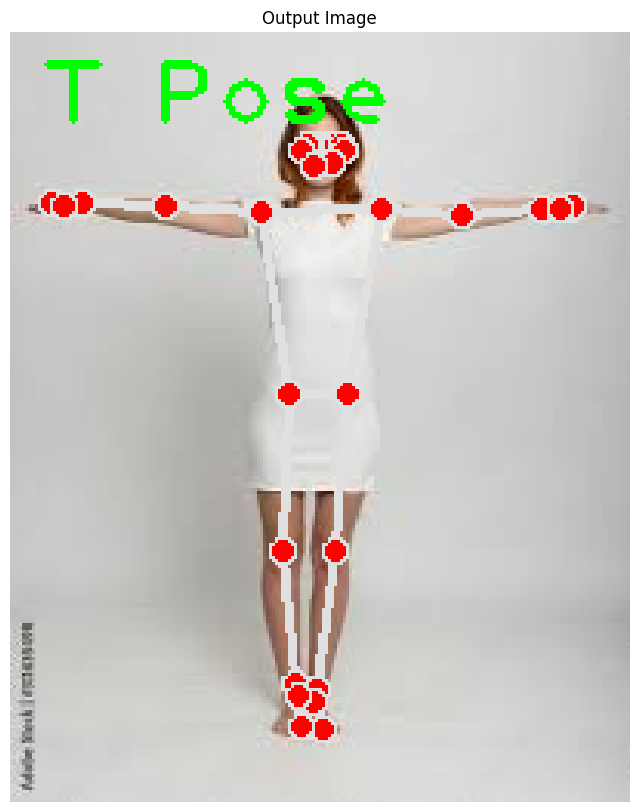

In [ ]:
image = cv2.imread('/content/download (5).jpg')
output_image, landmarks = detectPose(image, pose, display=False)
if landmarks:
    classifyPose(landmarks, output_image, display=True)

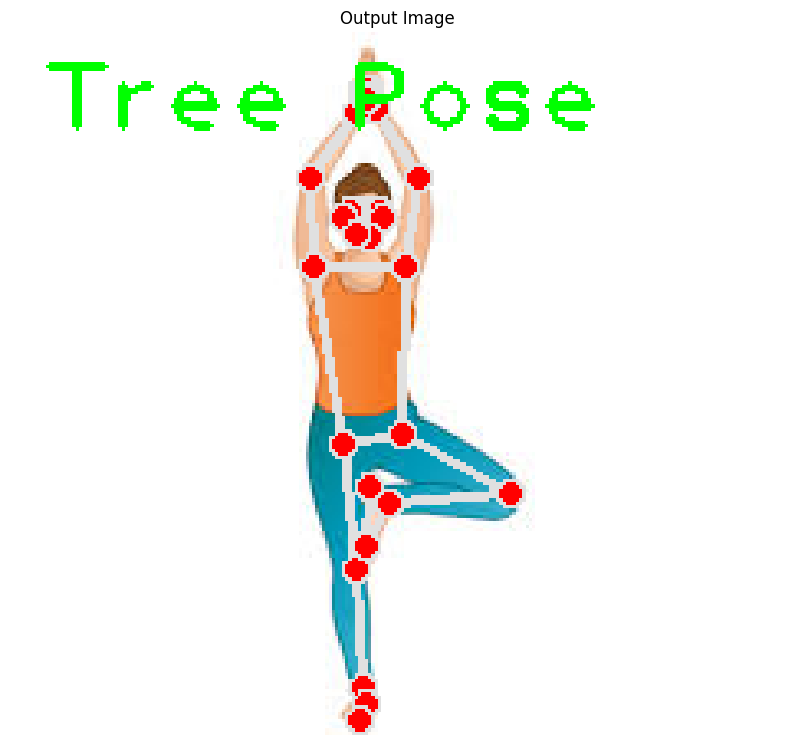

In [ ]:
image = cv2.imread('/content/download (1).jpg')
output_image, landmarks = detectPose(image, pose, display=False)
if landmarks:
    classifyPose(landmarks, output_image, display=True)

In [ ]:
pose_video = mp_pose.Pose(static_image_mode=False, min_detection_confidence=0.5, model_complexity=1)

# Initialize the VideoCapture object to read from the webcam.
video = cv2.VideoCapture(0)

# Initialize the VideoCapture object to read from a video stored in the disk.
#video = cv2.VideoCapture('/content/drive/MyDrive/My Video.mp4')


# Initialize a variable to store the time of the previous frame.
time1 = 0

# Iterate until the video is accessed successfully.
while video.isOpened():

    # Read a frame.
    ok, frame = video.read()

    # Check if frame is not read properly.
    if not ok:

        # Break the loop.
        break

    # Flip the frame horizontally for natural (selfie-view) visualization.
    frame = cv2.flip(frame, 1)

    # Get the width and height of the frame
    frame_height, frame_width, _ =  frame.shape

    # Resize the frame while keeping the aspect ratio.
    frame = cv2.resize(frame, (int(frame_width * (640 / frame_height)), 640))

    # Perform Pose landmark detection.
    frame, _ = detectPose(frame, pose_video, display=False)

    # Set the time for this frame to the current time.
    time2 = time()

    # Check if the difference between the previous and this frame time &gt; 0 to avoid division by zero.
    if (time2 - time1) > 0:

        # Calculate the number of frames per second.
        frames_per_second = 1.0 / (time2 - time1)

        # Write the calculated number of frames per second on the frame.
        cv2.putText(frame, 'FPS: {}'.format(int(frames_per_second)), (10, 30),cv2.FONT_HERSHEY_PLAIN, 2, (0, 255, 0), 3)

    # Update the previous frame time to this frame time.
    # As this frame will become previous frame in next iteration.
    time1 = time2

    # Display the frame.
    cv2.imshow('Pose Detection', frame)

    # Wait until a key is pressed.
    # Retreive the ASCII code of the key pressed
    k = cv2.waitKey(1) & 0xFF

    # Check if 'ESC' is pressed.
    if(k == 27):

        # Break the loop.
        break

# Release the VideoCapture object.
video.release()

# Close the windows.
cv2.destroyAllWindows()

In [ ]:
import cv2

camera_video = cv2.VideoCapture('sample.mp4')

# Initialize a resizable window.
cv2.namedWindow('Pose Classification', cv2.WINDOW_NORMAL)

# Iterate until the webcam is accessed successfully.
while camera_video.isOpened():

    # Read a frame.
    ok, frame = camera_video.read()

    # Check if frame is not read properly.
    if not ok:

        # Continue to the next iteration to read the next frame and ignore the empty camera frame.
        continue

    # Flip the frame horizontally for natural (selfie-view) visualization.
    frame = cv2.flip(frame, 1)

    # Get the width and height of the frame
    frame_height, frame_width, _ =  frame.shape

    # Resize the frame while keeping the aspect ratio.
    frame = cv2.resize(frame, (int(frame_width * (640 / frame_height)), 640))

    # Perform Pose landmark detection.
    frame, landmarks = detectPose(frame, pose_video, display=False)

    # Check if the landmarks are detected.
    if landmarks:

        # Perform the Pose Classification.
        frame, _ = classifyPose(landmarks, frame, display=False)

    # Display the frame.
    cv2.imshow('Pose Classification', frame)

    # Wait until a key is pressed.
    # Retreive the ASCII code of the key pressed
    k = cv2.waitKey(1) & 0xFF

    # Check if 'ESC' is pressed.
    if(k == 27):

        # Break the loop.
        break

# Release the VideoCapture object and close the windows.
camera_video.release()
cv2.destroyAllWindows()

In [ ]:
import cv2 as cv
from cvzone.PoseModule import PoseDetector

video= cv.VideoCapture('/content/drive/MyDrive/My Video.mp4')
while True:
    ret,img = video.read()
    cv.imshow('frame',img)
    key = cv.waitKey(1)
    if key==27:
        break

ModuleNotFoundError: ignored